Synthetase activity dependence built in

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm

In [8]:
plt.rcParams.update({'font.size': 22})

In [377]:
def iteration(plasmids, cycA, tRNA, alanyl_tRNA, intra_alanine, synthetase, masp, transcription_rate, base_uptake, k_cat, tRNA_on, cycA_on, synthetase_on):
    alanine_starvation = False
    #Alanine import step
    intra_alanine += (base_uptake + k_cat * cycA)
    
    #Aminoacylation step
    if tRNA <= synthetase * 2.0 and tRNA <= intra_alanine: #if tRNA availability is limiting factor
        alanyl_tRNA += tRNA
        intra_alanine -= tRNA
        tRNA = 0
    elif intra_alanine <= tRNA and intra_alanine <= synthetase * 2.0: #if alanine is limiting factor 
        alanyl_tRNA += intra_alanine
        tRNA -= intra_alanine
        intra_alanine = 0
        alanine_starvation = True
    else: #if synthetase is limiting factor
        alanyl_tRNA += synthetase * 2.0
        intra_alanine -= synthetase * 2.0
        tRNA -= synthetase * 2.0
    
    #Transcription/Translation step
    tRNA += alanyl_tRNA #all alanyl-tRNA used in translation
    A_tRNA_demand = 0
    if tRNA_on == True:
        tRNA += ((transcription_rate*plasmids)/76) #length of alanine tRNA = 76 base pairs
    if cycA_on == True:
        A_tRNA_demand += 47*((transcription_rate*plasmids)/1413)
    if synthetase_on == True:
        A_tRNA_demand += 91*((transcription_rate*plasmids)/2628)
    
    if alanyl_tRNA > A_tRNA_demand:
        if cycA_on == True:
            cycA += ((transcription_rate*plasmids)/1413) #length of cycA mRNA = 1413 base pairs
        if synthetase_on == True:
            synthetase += ((transcription_rate*plasmids)/2628)
        masp += (alanyl_tRNA - A_tRNA_demand)/51
    else:
        if cycA_on == True:
            cycA += ((transcription_rate*plasmids)/1413)*(alanyl_tRNA/A_tRNA_demand)
        if synthetase_on == True:
            synthetase += ((transcription_rate*plasmids)/2628)*(alanyl_tRNA/A_tRNA_demand)
    alanyl_tRNA = 0
    
#     Degradation step
    if tRNA_on == True and alanine_starvation == True:
        tRNA = tRNA * (1-(np.log(2)/600)) #half life for tRNA with amino acid starvation = 10 mins
    if cycA_on == True:
        cycA = cycA * (1-(np.log(2)/72000))
    if synthetase_on == True:
        synthetase = synthetase * (1-(np.log(2)/72000))
    masp = masp * (1-(np.log(2)/72000))
    
    return(cycA, tRNA, intra_alanine, alanyl_tRNA, synthetase, masp)

In [310]:
def yield_over_time(plasmids, cycA, tRNA, intra_alanine, alanyl_tRNA, synthetase, masp, transcription_rate, base_uptake, k_cat, tRNA_on, cycA_on, synthetase_on, num_iterations):
    masp_values = [masp]
    alanine_values = [intra_alanine]
    tRNA_values = [tRNA]
    synth_values = [synthetase]
    for i in range(num_iterations):
        cycA, tRNA, intra_alanine, alanyl_tRNA, synthetase, masp = iteration(plasmids, cycA, tRNA, alanyl_tRNA, intra_alanine, synthetase, masp, transcription_rate, base_uptake, k_cat, tRNA_on, cycA_on, synthetase_on)
        alanine_values.append(intra_alanine)
        masp_values.append(masp)
        tRNA_values.append(tRNA)
        synth_values.append(synthetase)
    return(alanine_values, masp_values, tRNA_values, synth_values)

In [328]:
def species_plotter(plasmids, cycA, tRNA, intra_alanine, alanyl_tRNA, synthetase, masp, transcription_rate, base_uptake, k_cat, num_iterations, resolution):
    iteration_index = (np.arange(num_iterations+1))[::resolution]
    alanine_values, masp_values, tRNA_values, synth_values = yield_over_time(plasmids, cycA, tRNA, intra_alanine, alanyl_tRNA, synthetase, masp, transcription_rate, base_uptake, k_cat, True, False, True, num_iterations)
    plt.figure(figsize=(10,10))
#     plt.plot(iteration_index, alanine_values[::resolution])
#     plt.plot(iteration_index, masp_values[::resolution])
    plt.plot(iteration_index, tRNA_values[::resolution])
    plt.plot(iteration_index, synth_values[::resolution])

In [378]:
def timecourse_plotter(plasmids, cycA, tRNA, intra_alanine, alanyl_tRNA, synthetase, masp, transcription_rate, base_uptake, k_cat, num_iterations, resolution):
    iteration_index = (np.arange(num_iterations+1))[::resolution]
    all_alanine_values = []
    all_masp_values = []
    
    
    no_expression = yield_over_time(plasmids, cycA, tRNA, intra_alanine, alanyl_tRNA, synthetase, masp, transcription_rate, base_uptake, k_cat, False, False, False, num_iterations)
    all_alanine_values.append(no_expression[0][::resolution])
    all_masp_values.append(no_expression[1][::resolution])
    
    tRNA_expression = yield_over_time(plasmids, cycA, tRNA, intra_alanine, alanyl_tRNA, synthetase, masp, transcription_rate, base_uptake, k_cat, True, False, False, num_iterations)
    all_alanine_values.append(tRNA_expression[0][::resolution])
    all_masp_values.append(tRNA_expression[1][::resolution])
    
    synth_tRNA_expression = yield_over_time(plasmids, cycA, tRNA, intra_alanine, alanyl_tRNA, synthetase, masp, transcription_rate, base_uptake, k_cat, True, False, True, num_iterations)
    all_alanine_values.append(synth_tRNA_expression[0][::resolution])
    all_masp_values.append(synth_tRNA_expression[1][::resolution])
    
    all3_expression = yield_over_time(plasmids, cycA, tRNA, intra_alanine, alanyl_tRNA, synthetase, masp, transcription_rate, base_uptake, k_cat, True, True, True, num_iterations)
    all_alanine_values.append(all3_expression[0][::resolution])
    all_masp_values.append(all3_expression[1][::resolution])
    
    plt.figure(figsize=(10,10))
#     plt.plot(iteration_index, all_masp_values[0])
#     plt.plot(iteration_index, all_masp_values[1])
#     plt.plot(iteration_index, all_masp_values[2])
#     plt.plot(iteration_index, all_masp_values[3])
    plt.plot(iteration_index, all_alanine_values[0])
    plt.plot(iteration_index, all_alanine_values[1])
    plt.plot(iteration_index, all_alanine_values[2])
    plt.plot(iteration_index, all_alanine_values[3])

    plt.xlabel('Time/s')
#     plt.ylabel('log(MaSp concentration)/log(molecules/cell)')
    data = {'Time (s)':iteration_index, 'No expression':all_alanine_values[0], 'tRNA expressed':all_alanine_values[1],\
           'Synthetase and tRNA expressed':all_alanine_values[2], 'All 3 expressed':all_alanine_values[3]}
    df = pd.DataFrame(data)
    df.to_csv('./AlanineDataDegradation.csv', sep=',')
    plt.legend(['No expression', 'tRNA expressed', 'tRNA and synthetase expressed', 'tRNA, cycA and synthetase expressed'])
#     plt.title('MaSp production over time with varied gene expression')
#     plt.savefig('./Figures/SynthetaseConcentrationVsTime.png', bbox_inches='tight')
    return(df)

CPU times: user 984 ms, sys: 19.1 ms, total: 1 s
Wall time: 1.02 s


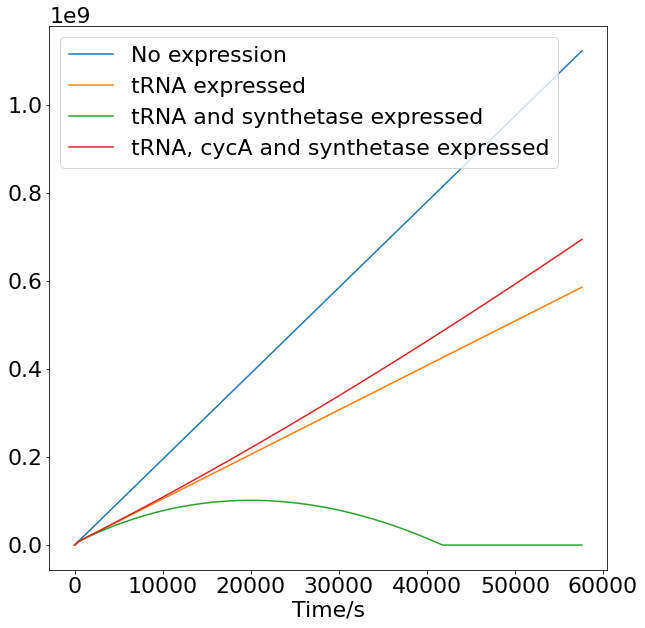

In [379]:
%%time
df = timecourse_plotter(plasmids=20, cycA=0, tRNA=4000, intra_alanine=0, alanyl_tRNA=0, synthetase=6695, masp=0, transcription_rate=45, base_uptake=23500, k_cat=0.9953, num_iterations=57600, resolution=100)

In [362]:
df

,Time (s),No expression,tRNA expressed,Synthetase and tRNA expressed,All 3 expressed
0,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1,100,7.843137e+03,8.992518e+03,8.931411e+03,8.872713e+03
2,200,1.568627e+04,2.030702e+04,2.018480e+04,2.006741e+04
3,300,2.352941e+04,3.394350e+04,3.376018e+04,3.358408e+04
4,400,3.137255e+04,4.990196e+04,4.965753e+04,4.942274e+04
...,...,...,...,...,...
572,57200,4.486275e+06,1.494472e+07,2.632191e+07,3.684178e+07
573,57300,4.494118e+06,1.497097e+07,2.636793e+07,3.694480e+07
574,57400,4.501961e+06,1.499723e+07,2.641394e+07,3.704795e+07
575,57500,4.509804e+06,1.502348e+07,2.645996e+07,3.715124e+07


In [342]:
def timecourse_plotter2(plasmids, cycA, tRNA, intra_alanine, alanyl_tRNA, synthetase, masp, transcription_rate, base_uptake, k_cat, num_iterations):
    iteration_index = np.arange(num_iterations+1)
    all_alanine_values = []
    all_masp_values = []
    
    
    no_expression = yield_over_time(plasmids, cycA, tRNA, intra_alanine, alanyl_tRNA, synthetase, masp, transcription_rate, base_uptake, k_cat, True, False, True, num_iterations)
    all_alanine_values.append(no_expression[0])
    all_masp_values.append(no_expression[1])
    
    expression = yield_over_time(plasmids, cycA, tRNA, intra_alanine, alanyl_tRNA, synthetase, masp, transcription_rate, base_uptake, k_cat, True, True, True, num_iterations)
    all_alanine_values.append(expression[0])
    all_masp_values.append(expression[1])
    
    plt.figure(figsize=(10,10))
    plt.plot(iteration_index, all_masp_values[0])
    plt.plot(iteration_index, all_masp_values[1])

    plt.xlabel('Time/s')
    plt.ylabel('log(MaSp concentration)/log(molecules/cell)')
    plt.legend(['Expression state 1', 'Expression state 2'])
#     plt.title('MaSp production over time with varied gene expression')

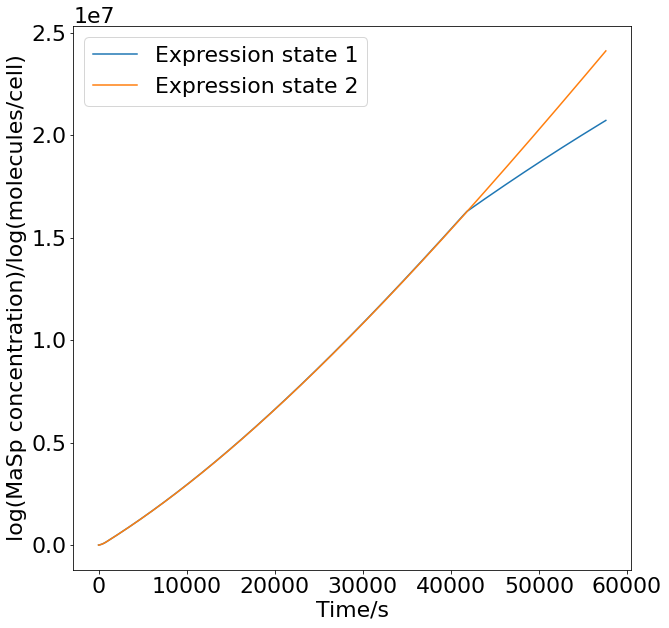

In [343]:
timecourse_plotter2(plasmids=20, cycA=0, tRNA=4000, intra_alanine=0, alanyl_tRNA=0, synthetase=6695, masp=0, transcription_rate=45, base_uptake=23500, k_cat=0.9953, num_iterations=57600)